In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Flows are coded as (x, y) where +y is upward in the image; value is in pixels

In [4]:
from bootraft import BootRaft
from raft import ThingsClassifier, CentroidRegressor
args = set_args()

# net = torch.nn.DataParallel(RAFT(args))
# net = torch.nn.DataParallel(BootRaft(args))
# net = torch.nn.DataParallel(ThingsClassifier(args))
net = torch.nn.DataParallel(CentroidRegressor(args))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
ls ../checkpoints/*thing*

../checkpoints/10000_thingness-tdw-continue2.pth
../checkpoints/10000_thingness-tdw-continue.pth
../checkpoints/10000_thingness-tdw-selfsup-bs4.pth
../checkpoints/15000_thingness-tdw-continue2.pth
../checkpoints/15000_thingness-tdw-continue.pth
../checkpoints/15000_thingness-tdw-selfsup-bs4.pth
../checkpoints/20000_thingness-tdw-continue2.pth
../checkpoints/20000_thingness-tdw-continue.pth
../checkpoints/20000_thingness-tdw-selfsup-bs4.pth
../checkpoints/25000_thingness-tdw-continue2.pth
../checkpoints/25000_thingness-tdw-selfsup-bs4.pth
../checkpoints/30000_thingness-tdw-selfsup-bs4.pth
../checkpoints/35000_thingness-tdw-selfsup-bs4.pth
../checkpoints/40000_thingness-tdw-selfsup-bs4.pth
../checkpoints/45000_thingness-tdw-selfsup-bs4.pth
../checkpoints/5000_thingness-roboall-selfsup-bs4.pth
../checkpoints/5000_thingness-roboberk-selfsup-bs4.pth
../checkpoints/5000_thingness-tdw-continue2.pth
../checkpoints/5000_thingness-tdw-continue.pth
../checkpoints/5000_thingness-tdw.pth
../checkpo

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# load_path = '../checkpoints/raft-tdw-bn-fullplay.pth'
# load_path = '../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth'
# load_path = '../models/raft-sintel.pth'
# load_path = '../checkpoints/thingness-tdw-continue.pth'
load_path = '../checkpoints/5000_centroid-tdw-scaled.pth'
# load_path = '../checkpoints/40000_thingness-tdw-selfsup-bs4.pth'
# load_path = '../checkpoints/thingness-roboberk-selfsup-bs4.pth'

net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [7]:
net.cuda()
net = net.train()
# net.module.freeze_bn()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
thing_path = '../checkpoints/45000_thingness-tdw-selfsup-bs4.pth'
act_net = torch.nn.DataParallel(ThingsClassifier(args))
act_net.load_state_dict(torch.load(thing_path), strict=False)



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [9]:
act_net.cuda()
act_net = act_net.train()
# act_net.module.freeze_bn()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(32)],
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, centroid=False, thresh=None):
    dataset.is_test = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        if thingness:
            pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            pred = flow_viz.flow_to_image(tensor_to_arr(pred))
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  

def viz_h0_prediction(thingness_model, centroid_model, dataset, ex=0, iters=[1,6,12], thresh=None):
    pass



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


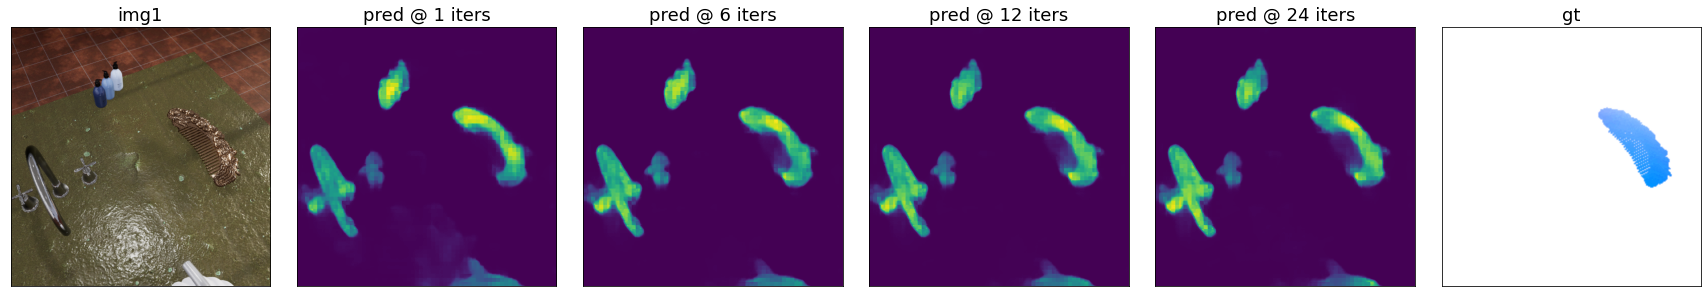

In [14]:
viz_raft_prediction(act_net, tdw_dataset, ex=1, iters=[1,6,12,24], thingness=True, thresh=None)

In [15]:
# img1, img2, _, _ = tdw_dataset[1]
# _, pred = net(img1.cuda()[None], img1.cuda()[None], iters=12, test_mode=True)

# _, thing = act_net(img1.cuda()[None], img1.cuda()[None], iters=12, test_mode=True)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


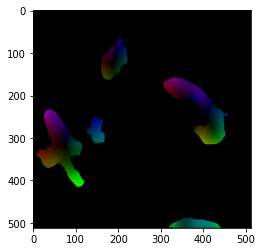

In [16]:
# from dorsalventral.data.utils import FlowToRgb
# viz(FlowToRgb(max_speed=0.5)(pred) * (torch.sigmoid(thing) > 0.1).float())

In [20]:
pred.amin()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(-140.0044, device='cuda:0', grad_fn=<AminBackward>)

In [32]:
import bootraft
kpnet = bootraft.KpPrior(
    net, act_net, normalize_coordinates=True, randomize_background=True, resolution=16
)

img1, img2, _, _ = tdw_dataset[100]
kp_prior = kpnet(img1.cuda()[None], img2.cuda()[None], iters=6, test_mode=True)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


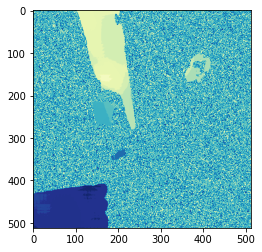

In [33]:
h0 = kp_prior[0].max(-3)[1].detach().cpu().numpy()
plt.imshow(h0, cmap='YlGnBu')
plt.show()

In [16]:
def normalize(img):
    return 2.0 * (img / 255.) - 1.0
img1, img2, flow, _ = tdw_dataset[1]
# fmap1, fmap2 = net.module.fnet([normalize(img1[None].cuda()), normalize(img2[None].cuda())])
# ctx = net.module.cnet(img1[None].cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow))
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, return_errormap=False)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
print(load_path)

../models/raft-sintel.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


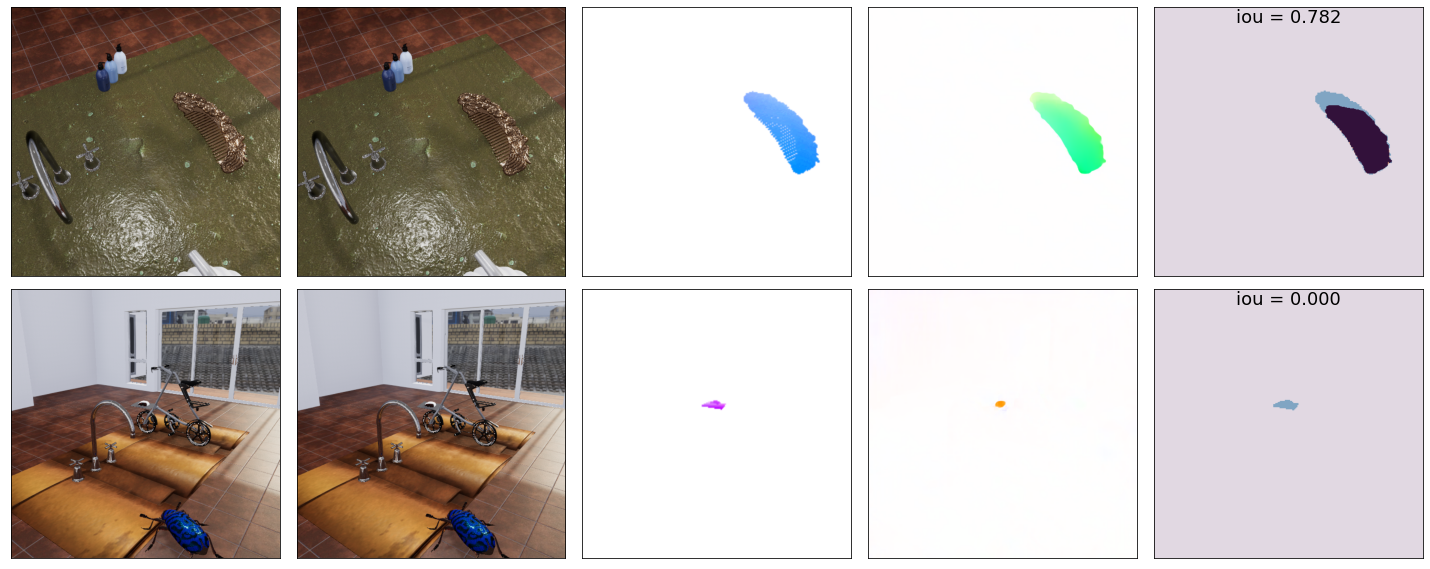

In [48]:
tdw_dataset.is_test = False
tdw_dataset.max_start_frame = 5
visualize_error_maps(net, tdw_dataset, examples=[1,2], thresh=4)

In [325]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:15<01:55,  3.84it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.7764962111216519,
  'precision': 0.8384561253722288,
  'recall': 0.9122151587805122},
 {'iou_isnan': 0.042, 'precision_isnan': 0.068, 'recall_isnan': 0.048})

In [326]:
print(load_path)
tdw_dataset.max_start_frame = None
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:14<02:07,  3.48it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:11<00:00,  3.82it/s]


({'iou': 0.6240724749082448,
  'precision': 0.8703083461953551,
  'recall': 0.7079785642796534},
 {'iou_isnan': 0.028, 'precision_isnan': 0.182, 'recall_isnan': 0.034})

In [153]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.50it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


({'iou': 0.8258794803290415,
  'precision': 0.9140077864749222,
  'recall': 0.8990444173111047},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [154]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:16,  3.24it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


({'iou': 0.5279725941740948,
  'precision': 0.9000479561979515,
  'recall': 0.5769562252348509},
 {'iou_isnan': 0.03, 'precision_isnan': 0.308, 'recall_isnan': 0.032})

In [161]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:10,  3.38it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


({'iou': 0.7969608048584764,
  'precision': 0.9451550029757846,
  'recall': 0.8369056144481988},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [162]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.49it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


({'iou': 0.5751281585458882,
  'precision': 0.9517182482523737,
  'recall': 0.5998352226939102},
 {'iou_isnan': 0.026, 'precision_isnan': 0.214, 'recall_isnan': 0.028})

In [69]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:55,  3.83it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


({'iou': 0.8434272244586196,
  'precision': 0.9281359996793522,
  'recall': 0.9046012481700816},
 {'iou_isnan': 0.048, 'precision_isnan': 0.086, 'recall_isnan': 0.048})

In [70]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:49,  4.04it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.5981904560853916,
  'precision': 0.9346249676908188,
  'recall': 0.6332787538043337},
 {'iou_isnan': 0.03, 'precision_isnan': 0.26, 'recall_isnan': 0.03})

In [71]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:14<01:54,  3.86it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.8315872222955202,
  'precision': 0.9656698780014051,
  'recall': 0.8579017929928859},
 {'iou_isnan': 0.048, 'precision_isnan': 0.092, 'recall_isnan': 0.048})

In [16]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:10,  3.40it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.8303785279437017,
  'precision': 0.9182744638935051,
  'recall': 0.8974846304309999},
 {'iou_isnan': 0.048, 'precision_isnan': 0.084, 'recall_isnan': 0.048})

In [17]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:09,  3.42it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.581308515985887,
  'precision': 0.9267800688274951,
  'recall': 0.623141531366377},
 {'iou_isnan': 0.032, 'precision_isnan': 0.274, 'recall_isnan': 0.032})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


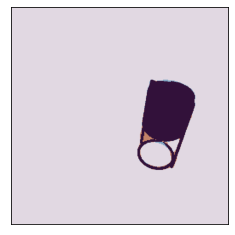

In [77]:
tdw_dataset.is_test = False
metrics = plot_errormap(net, tdw_dataset, ex=41, thresh=4, iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


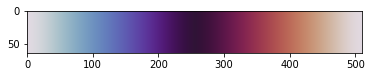

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=0,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
    training_frames='../datasets/supervision_frames/model_split_4_threshargmax.json',
    testing_frames='../datasets/supervision_frames/model_split_4_threshargmax.json'
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
list(tdw_dataset.training_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [4], [48], [15], [11], [52]]

In [112]:
list(tdw_dataset.testing_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [44], [7], [14], [119], [6]]

In [122]:
data_blob = tdw_dataset[5]

selected frame 4


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
torch.randint?

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
x = torch.rand([4, 8, 64]).transpose(1,2)
inds = torch.randint(low=0, high=64, size=[4,6], dtype=torch.long)
b_inds = torch.arange(4, dtype=torch.long)[:,None].repeat(1,6)
inds = torch.stack([b_inds, inds])
x[list(inds)].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([4, 6, 8])

In [227]:
import kmeans
Knet = kmeans.KMeans(num_clusters=32, num_iters=50, append_coordinates=True).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [228]:
img1, img2, flow, _ = tdw_dataset[3]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [229]:
img = img1[None].to(torch.uint8).cuda()
labels = Knet(img)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


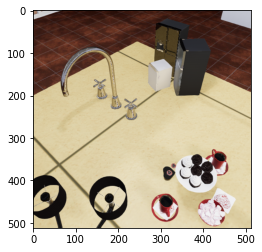

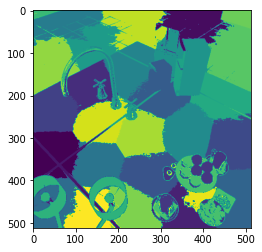

In [230]:
viz(img)
plt.show()
viz(labels)
plt.show()

In [18]:
import compute_training_frames as filtering
knet = torch.nn.DataParallel(filtering.KMeans(16, 50, True)).cuda()
seg_net = filtering.VideoSegmentationModel(model=knet, num_input_frames=1).cuda()
motion_net = net
explain_net = filtering.ExplainedAwayMotion(motion_net, seg_net)

def viz_segments(net, dataset, ex=0, iters=12, test_mode=True):
    img1, img2 = dataset[ex][:2]
    score = net(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    fig, axes = plt.subplots(1,4, figsize=(12,4))
    
    axes[0].imshow((img1 / 255.).permute(1,2,0).numpy())
    axes[1].imshow(net.motion_segments[0].detach().cpu().numpy(), cmap='magma')
    axes[2].imshow(net.static_segments[0].detach().cpu().numpy(), cmap='plasma')
    axes[3].imshow(net.out_segments[0].detach().cpu().numpy(), cmap='YlGnBu')
    
    titles = ['Image1', 'MotionSeg', 'StaticSegs', 'FinalSegs']
    for i,ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=20)
        
    plt.tight_layout()
    plt.show()
    
    return score


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


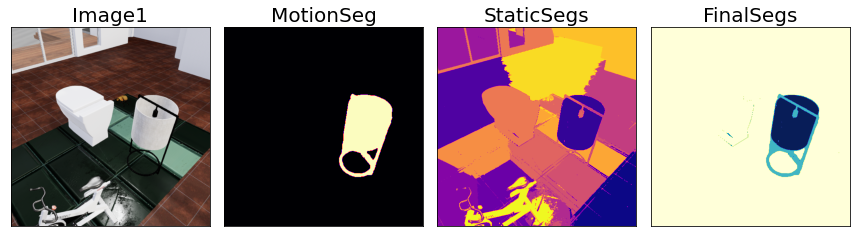

0.020595550537109375

In [19]:
viz_segments(explain_net, tdw_dataset, ex=41)

# read in robonet

In [20]:
import dorsalventral.data.robonet as robonet
import dorsalventral.vis_utils as vis_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
robonet.get_robot_names()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['berkeley_sawyer',
 'berkeley_widowx',
 'google',
 'meta_data.pkl',
 'penn_baxter_left',
 'penn_baxter_right',
 'penn_kuka',
 'stanford_fetch',
 'stanford_franka',
 'stanford_franka_corr_noise']

In [339]:
robonet_dataset = robonet.RobonetDataset(sequence_length=2)

Using 700 files from robots with names ['berkeley_sawyer', 'berkeley_widowx', 'google', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [342]:
rmov = robonet_dataset[0]

filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj11308.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


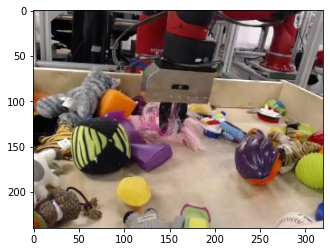

In [352]:
vis_utils.imshow(rmov['images'], None, 1)

In [50]:
robonet_dataset = raft_datasets.RobonetFlowDataset(sequence_length=2, 
                                                   dataset_names=["berk*"],
                                                   train=False
                                                  )
print(robonet_dataset.all_robots)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using 200 files from robots with names ['berk*']
['berkeley_sawyer', 'berkeley_widowx', 'google', 'meta_data.pkl', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj19970.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


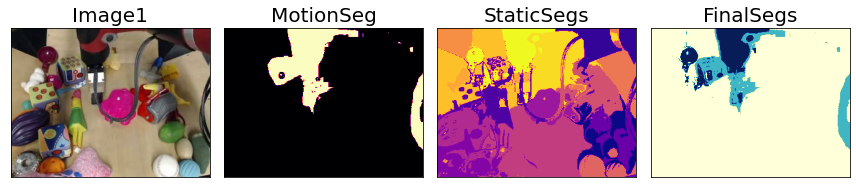

0.07240885496139526

In [23]:
viz_segments(explain_net, robonet_dataset, 15)

In [ ]:
net = nn.DataParallel()

In [51]:
load_path = '../models/raft-sintel.pth'
# load_path = '../checkpoints/raft-tdw-bn-fullplay.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


../models/raft-sintel.pth
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)


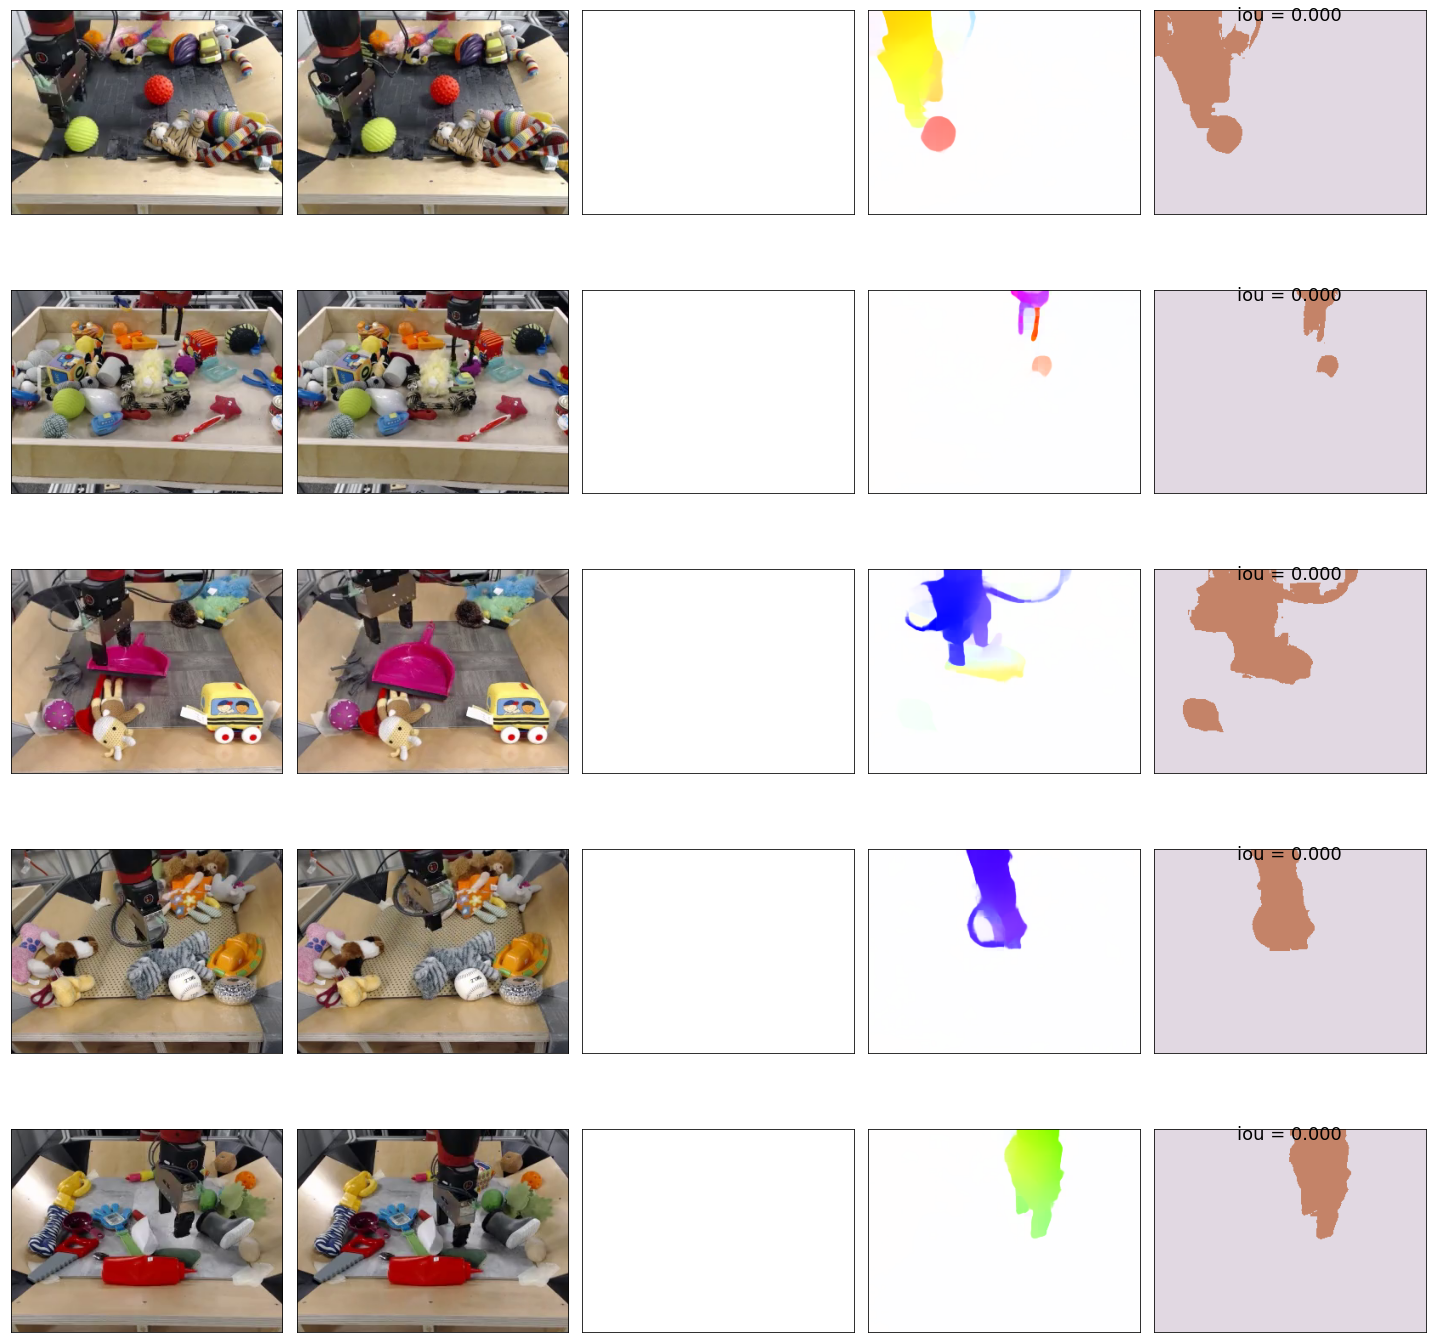

In [52]:
print(load_path)
visualize_error_maps(net, robonet_dataset, examples=range(5,10), thresh=0.5)